# In this notebook we train a model for each stim dimension for each bird

In [1]:
!nvidia-smi

Tue May 10 10:45:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K40c          Off  | 00000000:02:00.0 Off |                    0 |
| 23%   45C    P0    61W / 235W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40c          Off  | 00000000:03:00.0 Off |                    0 |
| 24%   

In [2]:
gpus = [0]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [20]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from itertools import product

In [4]:
tf.compat.v1.disable_eager_execution()

# Load data

In [5]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [6]:
dataset = Dataset('Starling')
analysis = 'stable_length'

In [7]:
species_folder = dataset.path_save
analysis_folder = os.path.join(species_folder, analysis)
log_folder = os.path.join(analysis_folder, 'log')
behavior_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/morph')

In [8]:
spec_file = os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli/spec_star_restricted.p')

In [9]:
behav_file = os.path.join(behavior_folder, 'behavior.p')

In [10]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [11]:
spec_df.tail()

,stim,id,wav,spec
3067,fh,124,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.55682534, -0.6060915, -0.6800735, -0.5795..."
3068,fh,125,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.5762845, -0.6195225, -0.5774481, -0.63291..."
3069,fh,126,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.5653498, -0.58962816, -0.6303803, -0.6005..."
3070,fh,127,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.4790637, -0.5114642, -0.62183285, -0.6796..."
3071,fh,128,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.5208054, -0.5728106, -0.62339747, -0.6818..."


In [12]:
group1_behav = pickle.load(open(os.path.join(behavior_folder, 'group1_behav.p'), 'rb'))
group2_behav = pickle.load(open(os.path.join(behavior_folder, 'group2_behav.p'), 'rb'))
group3_behav = pickle.load(open(os.path.join(behavior_folder, 'group3_behav.p'), 'rb'))

In [13]:
behav_df = pd.concat([group1_behav, group2_behav, group3_behav]).reset_index(drop=True)

In [14]:
behav_df.tail()

,index,min_val,max_val,slope,inflection,subj,group,metric
123,df,0.018225,0.951094,0.202028,48.683433,B1101,Group 3,behav
124,fg,0.086618,0.913664,1.151891,78.842110,B1222,Group 3,behav
125,fg,0.047706,0.976152,0.275545,76.420456,B1101,Group 3,behav
126,fh,0.066304,0.916032,0.231404,67.285280,B1222,Group 3,behav
127,fh,0.052882,0.980467,0.158747,74.250978,B1101,Group 3,behav


In [15]:
behav_subjs = sorted(behav_df.subj.unique())

In [16]:
spec_h, spec_w = spec_df.spec[0].shape
print(spec_h, spec_w)

186 76


In [17]:
spec_list = spec_df.spec.values.tolist()

## we need to first aggregate behavior data to response accuracy each bird at each morph position

In [18]:
def check_reverse(subj, morph_dim):
    if subj in ['B1088', 'B1105']:
        if morph_dim in [a+b for a, b in list(product('efcd', 'gh'))]:
            return True
        else:
            return False
    elif subj in ['B1101', 'B1222']:
        if morph_dim in [a+b for a, b in list(product('cd', 'ef'))]:
            return True
        else:
            return False
    else:
        return False

In [21]:
behav_df_agg = pd.DataFrame()
positions = np.arange(1, 129, 1, dtype=int)
behav_subjs = behav_df.subj.unique()
for subj in behav_subjs:
    subj_morph_dims = behav_df[behav_df.subj==subj]['index'].unique()
    for dim in subj_morph_dims:
        dim_vals = behav_df[(behav_df.subj==subj) & (behav_df['index']==dim)].values.tolist()[0][1:5]
        specs = spec_df[spec_df.stim==dim].spec.values.tolist()
        dim_fits = four_param_logistic([0.001, 0.999]+dim_vals[2:])(positions)
        if check_reverse(subj, dim):
            dim_fits = [1 - fit_val for fit_val in dim_fits]
        dim_df = pd.DataFrame({'id': positions,
                               'fit': dim_fits,
                               'spec': specs})
        dim_df['subj'] = subj
        dim_df['stim'] = dim
        behav_df_agg = pd.concat([behav_df_agg, dim_df]).reset_index(drop=True)

In [22]:
behav_df_agg['one_hot'] = behav_df_agg['fit'].apply(lambda x: [1-x, x])

In [23]:
behav_df_agg.tail()

,id,fit,spec,subj,stim,one_hot
16379,124,0.998629,"[[-0.55682534, -0.6060915, -0.6800735, -0.5795...",B1101,fh,"[0.0013707920058949608, 0.998629207994105]"
16380,125,0.998684,"[[-0.5762845, -0.6195225, -0.5774481, -0.63291...",B1101,fh,"[0.001316381594144156, 0.9986836184058558]"
16381,126,0.998730,"[[-0.5653498, -0.58962816, -0.6303803, -0.6005...",B1101,fh,"[0.0012699532633602129, 0.9987300467366398]"
16382,127,0.998770,"[[-0.4790637, -0.5114642, -0.62183285, -0.6796...",B1101,fh,"[0.0012303366190812293, 0.9987696633809188]"
16383,128,0.998803,"[[-0.5208054, -0.5728106, -0.62339747, -0.6818...",B1101,fh,"[0.0011965327193077524, 0.9988034672806922]"


0.9989999631198078


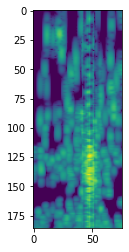

In [29]:
plt.imshow(behav_df_agg[(behav_df_agg.subj=='B1101') & (behav_df_agg.stim=='ce')].spec.tolist()[0])
print(behav_df_agg[(behav_df_agg.subj=='B1101') & (behav_df_agg.stim=='ce')].fit.tolist()[0])

0.9989962781906084


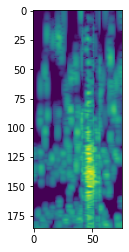

In [30]:
plt.imshow(behav_df_agg[(behav_df_agg.subj=='B1101') & (behav_df_agg.stim=='ac')].spec.tolist()[-1])
print(behav_df_agg[(behav_df_agg.subj=='B1101') & (behav_df_agg.stim=='ac')].fit.tolist()[-1])

## Define model

In [21]:
clear_session()

Groups:
1. ABCD vs EFGH
2. ABGH vs EFCD
3. ABEF vs CDGH

### First we make sure AE1 and AG1 are the same thing

In [31]:
behav_df_agg.tail()

,id,fit,spec,subj,stim,one_hot
16379,124,0.998629,"[[-0.55682534, -0.6060915, -0.6800735, -0.5795...",B1101,fh,"[0.0013707920058949608, 0.998629207994105]"
16380,125,0.998684,"[[-0.5762845, -0.6195225, -0.5774481, -0.63291...",B1101,fh,"[0.001316381594144156, 0.9986836184058558]"
16381,126,0.998730,"[[-0.5653498, -0.58962816, -0.6303803, -0.6005...",B1101,fh,"[0.0012699532633602129, 0.9987300467366398]"
16382,127,0.998770,"[[-0.4790637, -0.5114642, -0.62183285, -0.6796...",B1101,fh,"[0.0012303366190812293, 0.9987696633809188]"
16383,128,0.998803,"[[-0.5208054, -0.5728106, -0.62339747, -0.6818...",B1101,fh,"[0.0011965327193077524, 0.9988034672806922]"


In [22]:
AE1 = behav_df_agg[(behav_df_agg['stim']=='ae') & (behav_df_agg['id']==1)].spec.tolist()[0]

In [23]:
AF1 = behav_df_agg[(behav_df_agg['stim']=='af') & (behav_df_agg['id']==1)].spec.tolist()[0]

In [24]:
AC1 = behav_df_agg[(behav_df_agg['stim']=='ac') & (behav_df_agg['id']==1)].spec.tolist()[0]

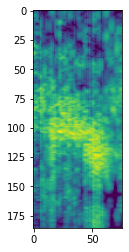

In [25]:
plt.imshow(AE1)

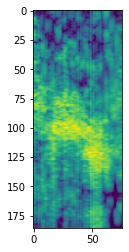

In [26]:
plt.imshow(AF1)

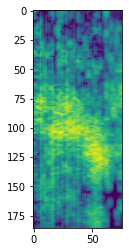

In [27]:
plt.imshow(AC1)

## Now we iterate through all subjects and all their dimensions

### define function to create and run model

In [21]:
class perceptual_loss_model:
    
    def __init__(self,
                 n_outputs,
                 train_type,
                 height,
                 width,
                 n_slices=None,
                 load_weight_file=None,
                 verbose=1):
        
        self.train_type=train_type
        self.verbose=verbose
        
        if self.train_type=='pre-train':
            assert n_slices, 'You must pass n_slices as an argument for pre-training!'
        
        self.set_paramters()
        self.model = self.build(n_outputs,
                                height, 
                                width, 
                                train_type=self.train_type, 
                                n_slices=n_slices, 
                                load_weight_file=load_weight_file,
                                verbose=self.verbose)
        
    def set_paramters(self,
                      patience=20, 
                      batch_size=10, 
                      epochs=1000, 
                      monitor='val_accuracy'):
        self.patience = patience
        self.batch_size = batch_size
        self.epochs = epochs
        self.monitor = monitor
    
    def build(self,
              n_outputs,
              height, 
              width, 
              train_type, 
              n_slices,
              load_weight_file=None,
              verbose=1):
        if train_type=='pre-train':
            
            model=self_VGG()
            model_inputs = []
            for i in range(np.product(n_slices)):
                model_inputs.append(Input(shape=(height, width, 3)))
            encodings = []
            for i in range(np.product(n_slices)):
                resized = layers.experimental.preprocessing.Resizing(224, 224,
                                                                     interpolation="bilinear")(model_inputs[i])
                encodings.append(model(resized))
            concated = layers.Concatenate(axis=1)(encodings)
            dense = layers.Dense(4096)(concated)
            model_output = layers.Dense(np.product(n_slices))(dense) 
            classifier = Model(model_inputs, model_output)
        
        elif train_type=='fine-tune':
            
            model=self_VGG()

            model_inputs = Input(shape=(height, width, 3))
            resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
            dense_1 = layers.Dense(2048, name='dense1', activation='relu')(model(resized))
            dense_2 = layers.Dense(2048, name='dense2', activation='relu')(dense_1)
            dense_3 = layers.Dense(1024, name='dense3', activation='relu')(dense_2)
            model_output = layers.Dense(n_outputs, name='output', activation ='softmax')(dense_3) # this needs to be changed for both temporal and spectral slices
            classifier = Model(model_inputs, model_output)
        else:
            raise ValueError('Training type can only be pre-train or fine-tune!')
        
        if verbose:
            print('Model successfully built.')
        
        if self.train_type=='fine-tune':
            assert load_weight_file, 'You must define the weight file to load for fine-tuning!'
        if load_weight_file:
            if verbose:
                print('Training model from existing weight file:')
                print(load_weight_file)
            classifier.load_weights(os.path.join(load_weight_file), by_name=True)

        return classifier
    
    def compile(self,
               loss='categorical_crossentropy',
               optimizer=Adam(0.00001),
               **kwargs):
        self.model.compile(loss=loss, optimizer=optimizer, **kwargs)
        
    def summary(self):
        self.model.summary()
        
    def train(self,
              input_data, 
              output_data, 
              run_folder, 
              log_message,
             **kwargs):
        
        with open(os.path.join(run_folder, 'training.log'), 'w') as file:
            file.write(log_message)

        trained_weights_file = os.path.join(run_folder, 'weights-improvement.h5')
        callbacks = [EarlyStopping(monitor=self.monitor, 
                                   patience=self.patience, 
                                   verbose=0),
                    ModelCheckpoint(filepath=trained_weights_file, 
                                    monitor=self.monitor, 
                                    save_best_only=True, 
                                    verbose=0)]

        self.model.fit(x = input_data, 
                       y = output_data, 
                       callbacks=callbacks, 
                       epochs=self.epochs, 
                       batch_size=self.batch_size, 
                       **kwargs)
    def predict(self,
                test_input,
                **kwargs):
        return self.model.predict(test_input)

In [32]:
def parse_inputs_outputs_exclude(df, subj, exclude_morphs, output_type='one_hot', robust=True, ):
    '''
    parse inputs and outputs from df, exclude certain dim
    df: behav_df_agg
    subj: subj to use
    exclude_morphs: morph dimension to exclude, can be one or more dimensions
    '''
    if isinstance(exclude_morphs, str):
        exclude_morphs = [exclude_morphs]
    subj_df = df[df.subj==subj]
    included_morphs = subj_df.stim.unique().tolist()
    for morph in exclude_morphs:
        if morph not in included_morphs:
            print(f'{morph} is not in this subject morphs')
            continue
        else:
            included_morphs.remove(morph)
    
    
    subj_df_filtered = subj_df[subj_df.stim.isin(included_morphs)].reset_index(drop=True)
    
    # if robust, ambiguious stims are not included in training
    if robust:
        subj_df_filtered = subj_df_filtered[subj_df_filtered.fit.apply(lambda x: True if (x>0.8) or (x<0.2) 
                                                                   else False)].reset_index(drop=True)
    
    subj_df_heldout = subj_df[subj_df.stim.isin(exclude_morphs)].reset_index(drop=True)
    
    inputs = subj_df_filtered.spec.values.tolist()
    inputs_3d = [np.stack([spec, spec, spec], axis=2) for spec in inputs]
    test_inputs = [np.stack([spec, spec, spec], axis=2) for spec in subj_df_heldout.spec.values.tolist()]
    
    if output_type=='one_hot':
        outputs = [[np.round(fit), np.round(1-fit)] for fit in subj_df_filtered.fit.values.tolist()]
        test_outputs = [[np.round(fit), np.round(1-fit)] for fit in subj_df_heldout.fit.values.tolist()]
    elif output_type=='exact':
        outputs = subj_df_filtered.fit.values.tolist()
        test_outputs = subj_df_heldout.fit.values.tolist()
    elif output_type=='exact_one_hot':
        outputs = [[fit, 1-fit] for fit in subj_df_filtered.fit.values.tolist()]
        test_outputs = [[fit, 1-fit] for fit in subj_df_heldout.fit.values.tolist()]
    else:
        outputs = [np.round(fit) for fit in subj_df_filtered.fit.values.tolist()]
        test_outputs = [np.round(fit) for fit in subj_df_heldout.fit.values.tolist()]
    
    return np.array(inputs_3d), np.array(outputs), np.array(test_inputs), np.array(test_outputs)

### example run, B1101, ad

In [30]:
behav_df_agg.tail()

,id,fit,spec,subj,stim,one_hot
16379,124,0.998629,"[[-0.55682534, -0.6060915, -0.6800735, -0.5795...",B1101,fh,"[0.0013707920058949608, 0.998629207994105]"
16380,125,0.998684,"[[-0.5762845, -0.6195225, -0.5774481, -0.63291...",B1101,fh,"[0.001316381594144156, 0.9986836184058558]"
16381,126,0.998730,"[[-0.5653498, -0.58962816, -0.6303803, -0.6005...",B1101,fh,"[0.0012699532633602129, 0.9987300467366398]"
16382,127,0.998770,"[[-0.4790637, -0.5114642, -0.62183285, -0.6796...",B1101,fh,"[0.0012303366190812293, 0.9987696633809188]"
16383,128,0.998803,"[[-0.5208054, -0.5728106, -0.62339747, -0.6818...",B1101,fh,"[0.0011965327193077524, 0.9988034672806922]"


In [41]:
subj = 'B1101'
morph = 'ad'
clear_session()

run_folder = extend_folder(results_folder, '2021_10_14_10_55_07', 'exclude_one_training', f'{subj}_{morph}')
test_results_file = os.path.join(run_folder, 'test_results.p')


inputs, outputs, test_inputs, test_outputs = parse_inputs_outputs_exclude(behav_df_agg, 
                                                                          subj, 
                                                                          morph, 
                                                                          output_type='exact_one_hot',
                                                                          robust=False)
model=self_VGG()
model_inputs = Input(shape=(spec_h, spec_w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
dense_1 = layers.Dense(2048, name='dense1', activation='relu')(model(resized))
dropout_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(2048, name='dense2', activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.2)(dense_2)
dense_3 = layers.Dense(1024, name='dense3', activation='relu')(dropout_2)
dropout_3 = layers.Dropout(0.2)(dense_3)
model_output = layers.Dense(2, name='output', activation ='softmax')(dropout_3) # this needs to be changed for both temporal and spectral slices
classifier = Model(model_inputs, model_output)
classifier.load_weights(os.path.abspath(pretrain_weight_file), by_name=True)

classifier.compile(loss='categorical_crossentropy',
                   optimizer=Adam(0.00001),
                   metrics=['accuracy'])

log_message = f'Fine-tuning on morph data, simulating {subj} \
training condition, with one morph label held out: {morph}'

with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write(log_message)

trained_weights_file = os.path.join(run_folder, 'weights-improvement.h5')

callbacks = [EarlyStopping(monitor='val_accuracy', 
                           patience=20, 
                           verbose=0),
            ModelCheckpoint(filepath=trained_weights_file, 
                            monitor='val_accuracy', 
                            save_best_only=True, 
                            verbose=0)]

classifier.fit(x = inputs, 
               y = outputs, 
               callbacks=callbacks, 
               epochs=1000, 
               batch_size=10, 
               validation_split=0.1)

test_prediction = classifier.predict(test_inputs)
pickle.dump([test_prediction[:,0], test_outputs[:,0]], open(os.path.join(run_folder, 'test_results.p'), 'wb'))
print(f'Done with {subj} {morph}')
del classifier

Train on 1728 samples, validate on 192 samples
Epoch 1/1000
1728/1728 [==============================] - 21s 12ms/sample - loss: 0.6882 - accuracy: 0.5590 - val_loss: 0.7061 - val_accuracy: 0.4479
Epoch 2/1000
1728/1728 [==============================] - 20s 12ms/sample - loss: 0.6155 - accuracy: 0.6383 - val_loss: 0.5871 - val_accuracy: 0.7448
Epoch 3/1000
1728/1728 [==============================] - 21s 12ms/sample - loss: 0.4181 - accuracy: 0.8264 - val_loss: 0.3049 - val_accuracy: 0.9479
Epoch 4/1000
1728/1728 [==============================] - 18s 11ms/sample - loss: 0.4003 - accuracy: 0.8339 - val_loss: 0.3553 - val_accuracy: 0.9115
Epoch 5/1000
1728/1728 [==============================] - 21s 12ms/sample - loss: 0.3470 - accuracy: 0.8663 - val_loss: 0.2580 - val_accuracy: 0.9531
Epoch 6/1000
1728/1728 [==============================] - 24s 14ms/sample - loss: 0.3109 - accuracy: 0.8906 - val_loss: 0.2353 - val_accuracy: 0.9635
Epoch 7/1000
1728/1728 [=============================

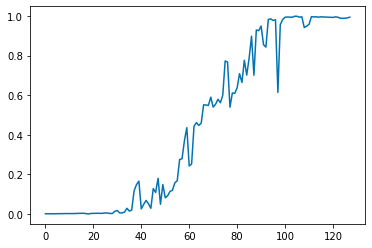

In [42]:
plt.plot(test_prediction[:,0])

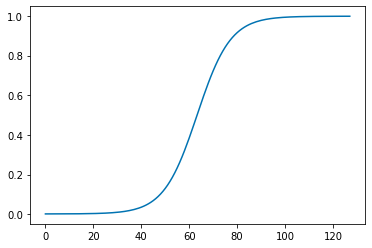

In [44]:
plt.plot(test_outputs[:,0])

# Now iterate

In [45]:
all_morphs = behav_df_agg.stim.unique().tolist()

In [46]:
select_morphs = ['fg']

In [47]:
from itertools import product

In [48]:
pretrain_weight_file = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/weights-improvement.h5')
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss')

In [49]:
clear_session()

In [53]:
for subj, morph in product(behav_subjs, all_morphs):
    
    inputs, outputs, test_inputs, test_outputs = parse_inputs_outputs_exclude(behav_df_agg, 
                                                                              subj, 
                                                                              morph, 
                                                                              output_type='exact_one_hot',
                                                                              robust=False)
    if not len(test_inputs):
        print(f'{subj} {morph} is not a valid combination, skipping...............')
        continue
    
    clear_session()
    if os.path.exists(os.path.join(results_folder, '2021_10_14_10_55_07', 
                                   'exclude_one_training', f'{subj}_{morph}', 'test_results.p')):
        print(f'{subj} {morph} already ran, skipping.....')
        continue
        
    run_folder = extend_folder(results_folder, '2021_10_14_10_55_07', 'exclude_one_training', f'{subj}_{morph}')
    test_results_file = os.path.join(run_folder, 'test_results.p')
    
    
    model=self_VGG()
    model_inputs = Input(shape=(spec_h, spec_w, 3))
    resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
    dense_1 = layers.Dense(2048, name='dense1', activation='relu')(model(resized))
    dropout_1 = layers.Dropout(0.2)(dense_1)
    dense_2 = layers.Dense(2048, name='dense2', activation='relu')(dropout_1)
    dropout_2 = layers.Dropout(0.2)(dense_2)
    dense_3 = layers.Dense(1024, name='dense3', activation='relu')(dropout_2)
    dropout_3 = layers.Dropout(0.2)(dense_3)
    model_output = layers.Dense(2, name='output', activation ='softmax')(dropout_3) # this needs to be changed for both temporal and spectral slices
    classifier = Model(model_inputs, model_output)
    classifier.load_weights(os.path.abspath(pretrain_weight_file), by_name=True)
    
    classifier.compile(loss='categorical_crossentropy',
                       optimizer=Adam(0.00001),
                       metrics=['accuracy'])

    log_message = f'Fine-tuning on morph data, simulating {subj} \
    training condition, with one morph label held out: {morph}'
    
    with open(os.path.join(run_folder, 'training.log'), 'w') as file:
        file.write(log_message)

    trained_weights_file = os.path.join(run_folder, 'weights-improvement.h5')
    
    callbacks = [EarlyStopping(monitor='val_accuracy', 
                               patience=20, 
                               verbose=0),
                ModelCheckpoint(filepath=trained_weights_file, 
                                monitor='val_accuracy', 
                                save_best_only=True, 
                                verbose=0)]

    history = classifier.fit(x = inputs, 
                           y = outputs, 
                           callbacks=callbacks, 
                           epochs=1000, 
                           batch_size=10, 
                           validation_split=0.1,
                           verbose=0)

    test_prediction = classifier.predict(test_inputs)
    pickle.dump([test_prediction[:,0], test_outputs[:,0]], open(os.path.join(run_folder, 'test_results.p'), 'wb'))
    try:
        plt.figure()
        plt.plot(history.history['val_accuracy'])
        plt.plot(history.history['accuracy'])
        plt.savefig(os.path.join(run_folder, 'test_results.png'))
        plt.close()
    except:
        print('Plotting history failed.')
    print(f'Done with {subj} {morph}')
    del classifier

B979 ae already ran, skipping.....
B979 af already ran, skipping.....
B979 ag already ran, skipping.....
B979 ah already ran, skipping.....
Done with B979 be
Done with B979 bf
Done with B979 bg
Done with B979 bh
Done with B979 ce
Done with B979 cf
Done with B979 cg
Done with B979 ch
Done with B979 de
Done with B979 df
Done with B979 dg
Done with B979 dh
ac is not in this subject morphs
B979 ac is not a valid combination, skipping...............
ad is not in this subject morphs
B979 ad is not a valid combination, skipping...............
bc is not in this subject morphs
B979 bc is not a valid combination, skipping...............
bd is not in this subject morphs
B979 bd is not a valid combination, skipping...............
eg is not in this subject morphs
B979 eg is not a valid combination, skipping...............
fg is not in this subject morphs
B979 fg is not a valid combination, skipping...............
eh is not in this subject morphs
B979 eh is not a valid combination, skipping.........

B1101 dg is not a valid combination, skipping...............
dh is not in this subject morphs
B1101 dh is not a valid combination, skipping...............
Done with B1101 ac
B1101 ad already ran, skipping.....
Done with B1101 bc
Done with B1101 bd
Done with B1101 eg
B1101 fg already ran, skipping.....
Done with B1101 eh
Done with B1101 fh
